# The Normality Assumption

## Introduction

Another assumption of linear regression is the normality assumption. This specifically means that the residuals should follow a normal distribution.

## Objectives

You will be able to:

* Describe the normality assumption of linear regression
* Diagnose issues with normality using visualizations and statistical tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

## Normality

Recall that a normal distribution looks something like this:

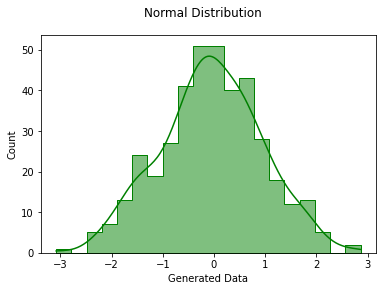

In [2]:
generated_data = stats.norm.rvs(size=400, random_state=7)
fig, ax = plt.subplots()
sns.histplot(generated_data, bins=20, element="step", kde=True, color="green", ax=ax)
ax.set_xlabel("Generated Data")
fig.suptitle("Normal Distribution");

One of the assumptions of linear regression is that the model **residuals** should follow a normal distribution.

## Visualizing Normality

The two main ways of visualizing normality are ***histograms*** (like the plot above) and ***Q-Q plots***.

### Histograms

We have already seen quite a few histograms at this point. They show the distribution of a single variable by showing the value of that variable along the x-axis and the counts of that variable that fall into a set of bins along the y-axis.

You are looking for a histogram shape that resembles the plot above, a "bell curve" shape.

Let's plot a histogram of the residuals from a model that predicts MPG using `displacement`, `horsepower`, `weight`, and `acceleration`.

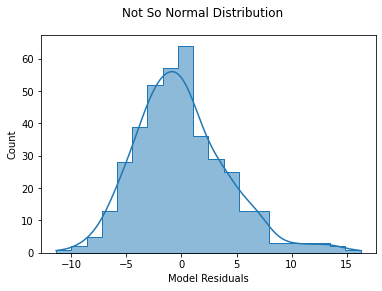

In [3]:
data = pd.read_csv('auto-mpg.csv', index_col=0)
y = data['mpg']
X = data[['displacement', 'horsepower', 'weight', 'acceleration']]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

fig, ax = plt.subplots()
sns.histplot(results.resid, bins=20, element="step", kde=True, ax=ax)
ax.set_xlabel("Model Residuals")
fig.suptitle("Not So Normal Distribution");

As you can see, the residuals from the actual model are a bit skewed, not quite normal.

### Q-Q Plots

In statistics, a ***Q-Q (quantile-quantile) plot*** is a probability plot, which is a graphical method for comparing two probability distributions by plotting their quantiles against each other.

We will use the Q-Q plot to compare the _actual_ data to _theoretical_ quantiles. In this case the theoretical quantiles would be the normal distribution (using the SciPy `stats.norm`).

When inspecting a Q-Q plot you are looking for the data points to follow the diagonal line as closely as possible.

First, here's an example using the generated normal data:

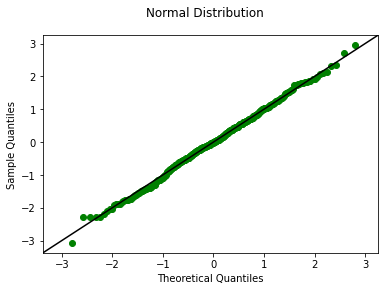

In [4]:
# Use qqplot function from StatsModels
fig, ax = plt.subplots()
sm.graphics.qqplot(generated_data, dist=stats.norm, line='45', fit=True, ax=ax)

# Customize plot appearance
scatter = ax.lines[0]
line = ax.lines[1]
scatter.set_markeredgecolor("green")
scatter.set_markerfacecolor("green")
line.set_color("black")
fig.suptitle("Normal Distribution");

There are a couple of places where the scatter plot diverges from the diagonal line because this data has some pseudo-random noise, but in general the points and the line are very close together.

Compare that to the plot for the auto MPG model residuals:

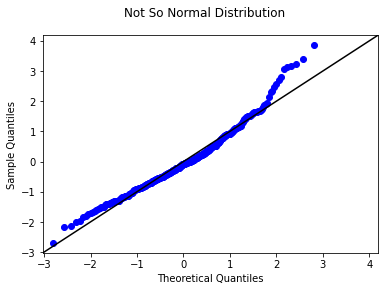

In [5]:
# Use qqplot function from StatsModels
fig, ax = plt.subplots()
sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True, ax=ax)

# Customize plot appearance
line = ax.lines[1]
line.set_color("black")
fig.suptitle("Not So Normal Distribution");

We see that the middle looks ok, but the ends, especially the higher end, are diverging from a normal distribution. This aligns with the skew that we observed in the histogram.

### More Examples

Below are some more examples of histograms and their associated Q-Q plots:

![normal distribution, peaked, skewed](inhouse_qq_plots.png)

You can also check out [this article](https://data.library.virginia.edu/understanding-q-q-plots/) for a more extended discussion of interpreting Q-Q plots.

## Statistical Testing for Normality

There are many potential statistical tests you could use to check for normality, since this kind of statistical test has applications beyond linear regression.

One test to consider is the [Jarque-Bera test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test), which uses skewness and kurtosis to create a test statistic that can be turned into a p-value using the Chi-squared distribution.

### Jarque-Bera Test Underlying Math

The test statistic $\text{JB}$ is defined like this:

$$ \large{ \text{JB} = \frac{n}{6}(S^2 + \frac{1}{4}(K-3)^2) } $$

Where $n$ is the number of data points, $S$ is the skewness, and $K$ is the kurtosis.

Below we compute `jb` for the generated data using the [StatsModels implementation](https://www.statsmodels.org/devel/generated/statsmodels.stats.stattools.jarque_bera.html):

In [6]:
n = generated_data.shape[0]
s = stats.skew(generated_data)
k = 3 + stats.kurtosis(generated_data)

jb = (n / 6.) * (s ** 2 + (1 / 4.) * (k - 3) ** 2)
jb

0.4519188967633713

Then we can calculate the p-value using the $\chi^2$ distribution survival function:

In [7]:
stats.chi2.sf(jb, 2)

0.7977504510815616

### Jarque-Bera Test with StatsModels

As usual, you don't actually need to write out this formula yourself. There is a function you can import from StatsModels instead ([documentation here](https://www.statsmodels.org/devel/generated/statsmodels.stats.stattools.jarque_bera.html)):

In [8]:
from statsmodels.stats.stattools import jarque_bera

In [9]:
jarque_bera(generated_data)

(0.4519188967633713,
 0.7977504510815616,
 -0.0332236549490571,
 2.849335177253925)

In [10]:
jarque_bera(results.resid)

(51.332550412287, 7.133099908986785e-12, 0.7146664114306294, 4.048721550463704)

The four values returned are:

1. $\text{JB}$ test statistic
2. The p-value for $\text{JB}$
3. Skew
4. Kurtosis

You can also view these values directly within a model summary. For example, these are the results for our auto MPG model. If you look in the lower right area you will see `Jarque-Bera (JB)` and `Prob(JB)`:

In [11]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     233.4
Date:                Fri, 17 Jun 2022   Prob (F-statistic):          9.63e-102
Time:                        15:28:49   Log-Likelihood:                -1120.6
No. Observations:                 392   AIC:                             2251.
Df Residuals:                     387   BIC:                             2271.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           45.2511      2.456     18.424   

### Interpreting Jarque-Bera Test Results

In the case of the Jarque-Bera test the **null hypothesis is that the distribution is normal**. A sufficiently low p-value means we reject the null hypothesis, i.e. that the distribution is not normal.

For the two datasets presented above:

* The generated data's **p-value is about 0.8**. This is much higher than the standard alpha of 0.05, so we fail to reject the null hypothesis and can **consider the distribution to be normal**
* The model residuals' **p-value is about 0.000000000007**. This is much lower than the standard alpha of 0.05, so we reject the null hypothesis and **do not consider the distribution to be normal**

Like with some other model assumption checks, this is "opposite" of the p-values you want for model significance or coefficient significance. A low p-value in the Jarque-Bera test is a "bad" outcome, indicating a problem with the model.

### Other Statistical Tests

As mentioned previously, there are several different options to test for normality, each of which uses a slightly different approach. Below are some additional tests you might want to consider:

#### Kolmogorov-Smirnov Test

The [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) compares the CDF (cumulative distribution function) of the two distributions. The null hypothesis is that the distributions are the same. There is an implementation in SciPy ([documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)):

In [12]:
stats.kstest(generated_data, "norm")

KstestResult(statistic=0.03437796417014605, pvalue=0.7184091664903246)

In [13]:
stats.kstest(results.resid, "norm")

KstestResult(statistic=0.32698123251877237, pvalue=8.001138817167398e-38)

#### Lilliefors Test

The [Lilliefors test](https://en.wikipedia.org/wiki/Lilliefors_test) is based on the Kolmogorov-Smirnov test and uses estimated parameters. The null hypothesis is that the specified data comes from a normal distribution. There is an implementation in StatsModels ([documentation here](https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.kstest_normal.html)), which returns the test statistic and the p-value:

In [14]:
from statsmodels.stats.diagnostic import kstest_normal

In [15]:
kstest_normal(generated_data)

(0.02646141843017441, 0.7280229807121467)

In [16]:
kstest_normal(results.resid)

(0.06804544956822389, 0.0009999999999998899)

#### Anderson-Darling Test

The [Anderson-Darling test](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) also compares the CDF of the two distributions. The null hypothesis is that the specified data comes from a normal distribution. There is an implementation in StatsModels ([documentation here](https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.normal_ad.html)), which returns the test statistic and p-value:

In [17]:
from statsmodels.stats.diagnostic import normal_ad

In [18]:
normal_ad(generated_data)

(0.306208049572092, 0.5639537893049426)

In [19]:
normal_ad(results.resid)

(2.5714252349764024, 1.688944543036666e-06)

#### Omnibus Test

The [Omnibus test](https://en.wikipedia.org/wiki/Omnibus_test) for normality tests for deviations that result from skewness or kurtosis. The null hypothesis is that the specified data comes from a normal distribution. There is an implementation in StatsModels ([documentation here](https://www.statsmodels.org/devel/generated/statsmodels.stats.stattools.omni_normtest.html)):

In [20]:
from statsmodels.stats.stattools import omni_normtest

In [21]:
omni_normtest(generated_data)

NormaltestResult(statistic=0.3290035852108211, pvalue=0.8483162362467015)

In [22]:
omni_normtest(results.resid)

NormaltestResult(statistic=38.35880421385135, pvalue=4.68264785079494e-09)

This result is also printed out in the model summary, in the lower left. Look for `Omnibus` and `Prob(Omnibus)`:

In [23]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     233.4
Date:                Fri, 17 Jun 2022   Prob (F-statistic):          9.63e-102
Time:                        15:28:49   Log-Likelihood:                -1120.6
No. Observations:                 392   AIC:                             2251.
Df Residuals:                     387   BIC:                             2271.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           45.2511      2.456     18.424   

#### How to Choose a Test

As you can see, there are a lot of options! Don't worry too much about choosing the best one. If you are especially interested in the topic, feel free to read more about how the tests work and what kinds of false positive and false negative results they might be susceptible to. But in general this is a fairly esoteric statistical topic and as a data professional you should be able to use any of these tests for your needs.

## Treating Normality Issues

Log transformations tend to be the most helpful when it comes to normality issues. Non-normality in the features or target is often associated with non-normality in the residuals. Below we plot the distributions of all data in the auto MPG model:

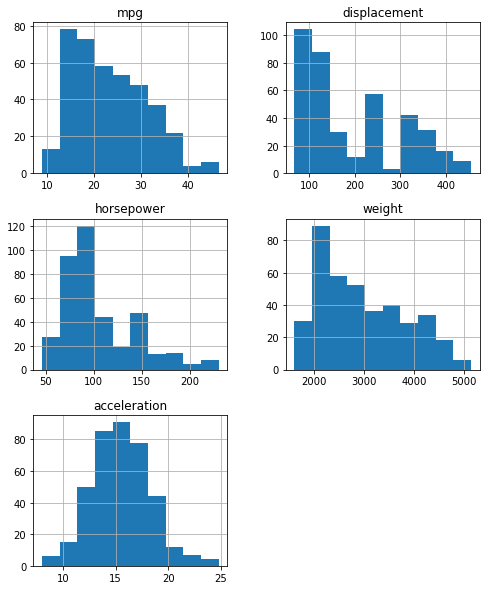

In [24]:
data[['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']]\
    .hist(figsize=(8, 10));

Then those same distributions after being log transformed:

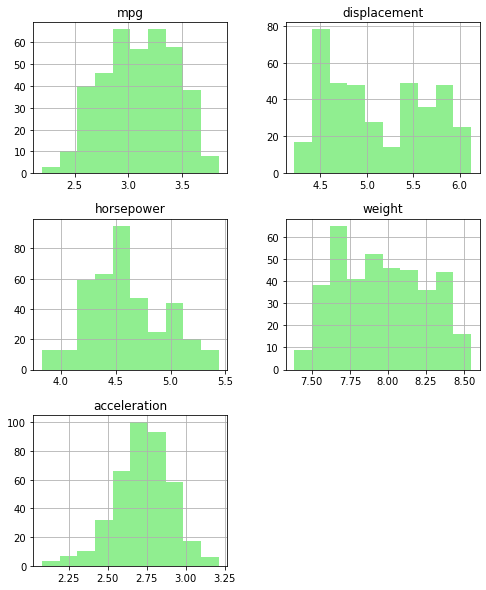

In [25]:
np.log(data[['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']])\
    .hist(figsize=(8, 10), color="lightgreen");

As you can see, for most variables, they still aren't fully normal, but they're closer. However `acceleration` looks more skewed now than before. So let's log transform everything except `acceleration`.

Then if we build a model using those log-transformed features and target, we see some improvement in the distribution of the residuals:

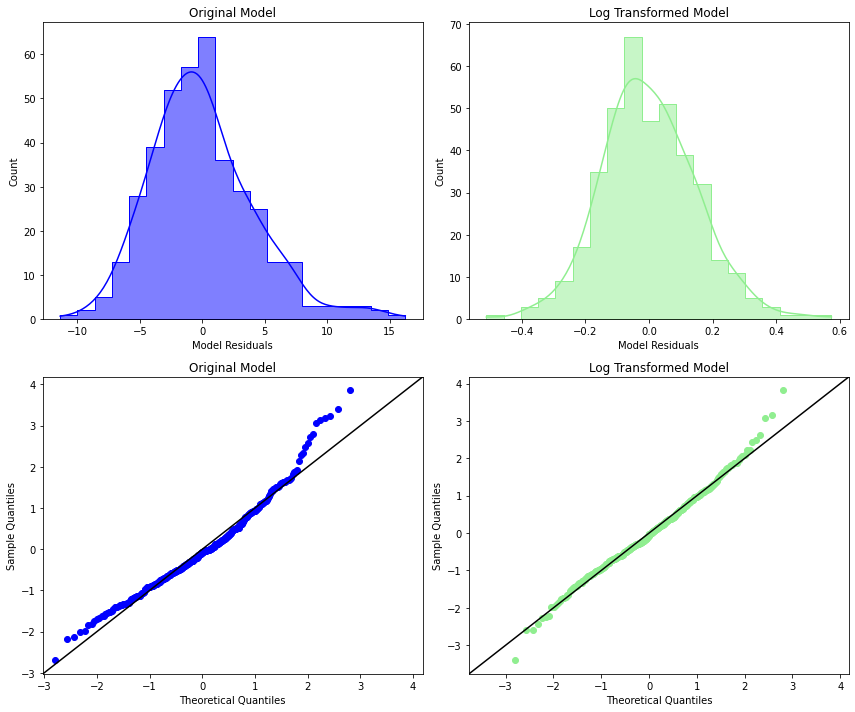

In [26]:
# Build log transformed model
y_log = np.log(data["mpg"])
X_log = pd.concat([np.log(data[['displacement', 'horsepower', 'weight']]), data[['acceleration']]], axis=1)
log_model = sm.OLS(y_log, sm.add_constant(X_log))
log_results = log_model.fit()

# Set up plot and properties of two models
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
resids = [results.resid, log_results.resid]
labels = ["Original Model", "Log Transformed Model"]
colors = ["blue", "lightgreen"]

# Plot histograms
for index, ax in enumerate(axes[0]):
    sns.histplot(resids[index], bins=20, element="step", kde=True, color=colors[index], ax=ax)
    ax.set_xlabel("Model Residuals")
    ax.set_title(labels[index])
    
# Plot Q-Q plots
for index, ax in enumerate(axes[1]):
    sm.graphics.qqplot(resids[index], dist=stats.norm, line='45', fit=True, ax=ax)
    scatter = ax.lines[0]
    line = ax.lines[1]
    scatter.set_markeredgecolor(colors[index])
    scatter.set_markerfacecolor(colors[index])
    line.set_color("black")
    ax.set_title(labels[index])
    
fig.tight_layout()

Looking at the p-values from the Jarque-Bera test, you can see we're getting a lot closer:

In [27]:
print(f"Original model:        {jarque_bera(results.resid)[1]}")
print(f"Log transformed model: {jarque_bera(log_results.resid)[1]}")

Original model:        7.133099908986785e-12
Log transformed model: 0.0036669351258854627


And using some other measures, we actually can't reject the null hypothesis!

In [28]:
print(f"Original model:        {kstest_normal(results.resid)[1]}")
print(f"Log transformed model: {kstest_normal(log_results.resid)[1]}")

Original model:        0.0009999999999998899
Log transformed model: 0.1610763758916161


In [29]:
print(f"Original model:        {normal_ad(results.resid)[1]}")
print(f"Log transformed model: {normal_ad(log_results.resid)[1]}")

Original model:        1.688944543036666e-06
Log transformed model: 0.08748354038810166


Keep in mind that log transformations are fundamentally changing the nature of the linear regression model to be multiplicative with respect to the original units rather than additive. So there may be a trade-off between model interpretability and meeting the normality assumption.

## Summary

The normality assumption for linear regression is related to the distribution of the model residuals. In this lesson you saw how to evaluate a model with respect to the normality assumption using histograms and Q-Q plots, as well as various different statistical tests. You also saw how log transformation in particular can help meet the normality assumption, or at least to get closer to normal residuals.